# Cal-CRAI Index: Society & Economy Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plots import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'society_economy_'  # will be used for naming newly created columns
csv_file_prefix = 'society' # for society & economy domain specifically, all files in this domain are named just society

input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(csv_file_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within societydomain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_population_ambulatory_disabilities',
  'percent_total_pop_american_indian_alaska_native',
  'percent_population_cognitive_disabilities',
  'est_gini_index',
  'hachman_index',
  'percent_children_household_financial_assistance',
  'percent_1miurban_10mirural',
  'avg_hpsscore_mental_shortage_metric',
  'real_percent_total_pop_over_65',
  'avg_hpsscore_primary_care_metric',
  'percent_total_pop_under_5',
  'asthma_related_ed_visits_per_10000_people_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'education_percent_2019',
  'avg_percent_population_homeless',
  'housing_burden_percent_2019',
  'sum_imp_water_bodies',
  'linguistic_isolation_percent_2019',
  'low_birth_weight_percent_2019',
  'Percent of households without air conditioning',
  'Percent of population employed and aged > 16 working outdoors',
  'poverty_percent_2019',
  'unemployment_percent_2019',
  'Number of Violent Crimes per 10,000 Population',
  'percent_population_

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_society_df = pd.read_csv(merged_output_file)
processed_society_df

,GEOID,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236,15.885023,58.256725,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500,0.000000,30.832177,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000,3.184713,30.832177,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836,14.240170,30.832177,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078,4.435484,30.832177,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265,13.194444,0.000000,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018,44.331984,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_society_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_society_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]

In [8]:
min_max_standardized_society_economy_metrics_df.head()

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.046803,0.000000,0.13134,0.000876,0.503770,0.962333,0.936422,0.158850,0.582567,...,0.134367,0.054054,0.012,0.280817,0.643066,0.012265,0.103753,0.109878,0.797158,0.004818
1,6001400200,0.040056,0.005464,0.13134,0.000323,0.483284,0.962333,0.900035,0.000000,0.308322,...,0.041344,0.000000,0.000,0.295405,0.643066,0.021277,0.105960,0.068337,0.797158,0.014672
2,6001400300,0.022958,0.006831,0.13134,0.000598,0.558828,0.962333,0.643873,0.031847,0.308322,...,0.104651,0.000000,0.080,0.275711,0.643066,0.015369,0.102649,0.088838,0.797158,0.028964
3,6001400400,0.036466,0.006831,0.13134,0.000537,0.622564,0.962333,0.622364,0.142402,0.308322,...,0.180879,0.000000,0.009,0.323851,0.643066,0.028617,0.221854,0.056948,0.797158,0.039271
4,6001400500,0.033679,0.001366,0.13134,0.001054,0.552568,0.962333,0.356797,0.044355,0.308322,...,0.180879,0.000000,0.017,0.265500,0.643066,0.050283,0.230684,0.086560,0.797158,0.078438


### 1d) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'Number of Violent Crimes per 10,000 Population' represents a communities vulnerability to violent crime. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [9]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_population_ambulatory_disabilities',
  'percent_total_pop_american_indian_alaska_native',
  'percent_population_cognitive_disabilities',
  'est_gini_index',
  'hachman_index',
  'percent_children_household_financial_assistance',
  'percent_1miurban_10mirural',
  'avg_hpsscore_mental_shortage_metric',
  'real_percent_total_pop_over_65',
  'avg_hpsscore_primary_care_metric',
  'percent_total_pop_under_5',
  'asthma_related_ed_visits_per_10000_people_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'education_percent_2019',
  'avg_percent_population_homeless',
  'housing_burden_percent_2019',
  'sum_imp_water_bodies',
  'linguistic_isolation_percent_2019',
  'low_birth_weight_percent_2019',
  'Percent of households without air conditioning',
  'Percent of population employed and aged > 16 working outdoors',
  'poverty_percent_2019',
  'unemployment_percent_2019',
  'Number of Violent Crimes per 10,000 Population',
  'percent_population_

In [10]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_society_economy_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_society_economy_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)

In [11]:
adjusted_vulnerable_df

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.953197,1.000000,0.13134,0.999124,0.496230,0.037667,0.936422,0.841150,0.417433,...,0.865633,0.945946,0.988000,0.719183,0.356934,0.987735,0.896247,0.890122,0.202842,0.995182
1,6001400200,0.959944,0.994536,0.13134,0.999677,0.516716,0.037667,0.900035,1.000000,0.691678,...,0.958656,1.000000,1.000000,0.704595,0.356934,0.978723,0.894040,0.931663,0.202842,0.985328
2,6001400300,0.977042,0.993169,0.13134,0.999402,0.441172,0.037667,0.643873,0.968153,0.691678,...,0.895349,1.000000,0.920000,0.724289,0.356934,0.984631,0.897351,0.911162,0.202842,0.971036
3,6001400400,0.963534,0.993169,0.13134,0.999463,0.377436,0.037667,0.622364,0.857598,0.691678,...,0.819121,1.000000,0.991000,0.676149,0.356934,0.971383,0.778146,0.943052,0.202842,0.960729
4,6001400500,0.966321,0.998634,0.13134,0.998946,0.447432,0.037667,0.356797,0.955645,0.691678,...,0.819121,1.000000,0.983000,0.734500,0.356934,0.949717,0.769316,0.913440,0.202842,0.921562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.994647,0.997268,NaN,0.999908,0.492815,0.223179,0.186802,0.868056,1.000000,...,0.555556,1.000000,0.940833,0.684172,0.982747,0.919346,0.698675,0.922551,0.569602,0.974706
9125,6115041001,0.916122,0.995902,NaN,0.999365,0.382985,0.223179,0.241183,1.000000,0.623633,...,0.755527,0.918919,0.940833,0.645271,0.982747,0.841549,0.480010,0.786130,0.569602,0.951389
9126,6115041002,0.908399,0.964481,NaN,0.998355,0.404183,0.223179,0.387853,1.000000,0.623633,...,0.755527,0.918919,0.940833,0.645271,0.982747,0.841549,0.480010,0.786130,0.569602,0.728563
9127,6115041101,0.831731,0.984973,NaN,0.998406,0.518424,0.223179,0.114964,0.556680,0.623633,...,0.755527,0.918919,0.940833,0.645271,0.982747,0.841549,0.480010,0.786130,0.569602,0.869974


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [12]:
averaged_indicators_society_economy = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6001400100,0.833535,0.195211,0.490106
1,6001400200,0.857176,0.195211,0.484806
2,6001400300,0.861305,0.195211,0.374237
3,6001400400,0.839637,0.195211,0.345822
4,6001400500,0.848987,0.195211,0.280632
...,...,...,...,...
9124,6115040902,0.877758,0.353915,0.300932
9125,6115041001,0.807107,0.353915,0.282449
9126,6115041002,0.804365,0.353915,0.338405
9127,6115041101,0.790099,0.353915,0.285522


Save Indicator dataframe as a csv

In [13]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_society_economy.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [14]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.377953904778967


### 2a) Min-max standardize the summed columns

In [15]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [16]:
min_max_domain

,GEOID,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6001400100,0.0,2.377954,0.638723
1,6001400200,0.0,2.377954,0.646435
2,6001400300,0.0,2.377954,0.601674
3,6001400400,0.0,2.377954,0.580613
4,6001400500,0.0,2.377954,0.557130
...,...,...,...,...
9124,6115040902,0.0,2.377954,0.644506
9125,6115041001,0.0,2.377954,0.607022
9126,6115041002,0.0,2.377954,0.629400
9127,6115041101,0.0,2.377954,0.601162


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [17]:
min_max_standardized_society_economy_domain = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [18]:
gdf = add_census_tracts(min_max_standardized_society_economy_domain)

Let's look at some summary statistics for this domain:

In [19]:
domain_summary_stats(gdf, 'summed_indicators_society_economy_domain_min_max_standardized')

Median summed_indicators_society_economy_domain_min_max_standardized domain value: 0.5811401822643003
Mean summed_indicators_society_economy_domain_min_max_standardized domain value: 0.5846874792509703


In [20]:
gdf.columns

Index(['GEOID',
       'summed_indicators_society_economy_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [21]:
domain_prefix

'society_economy_'

Now let's visualize the entire domain!

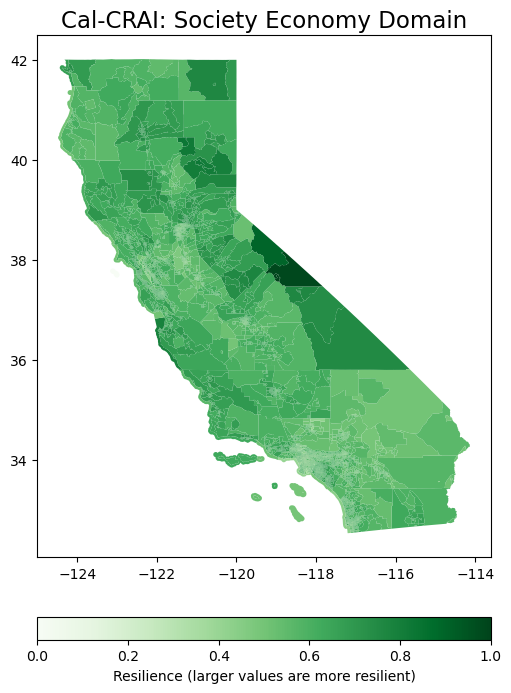

In [22]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


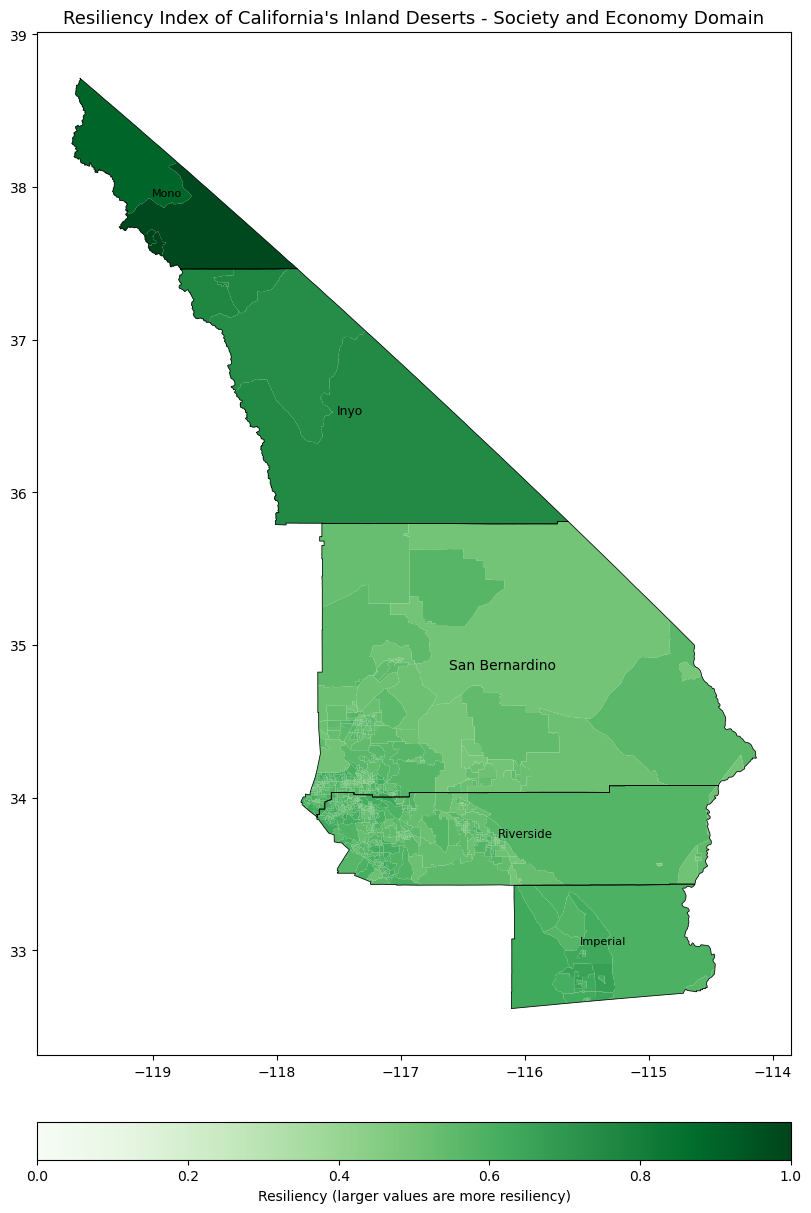

In [23]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


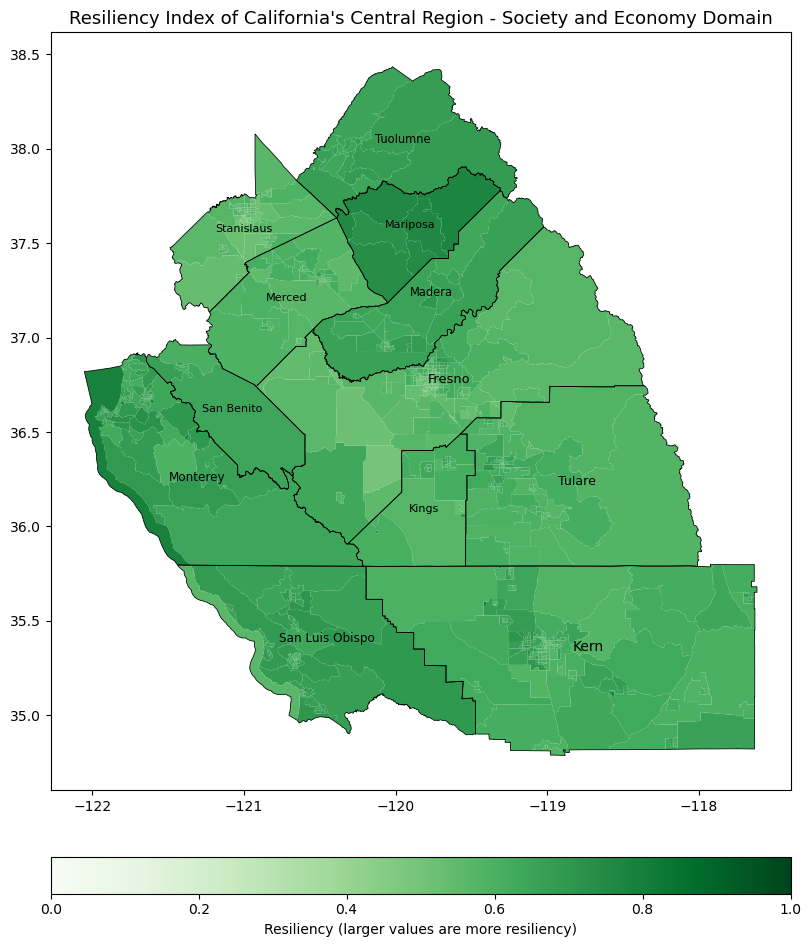

In [24]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


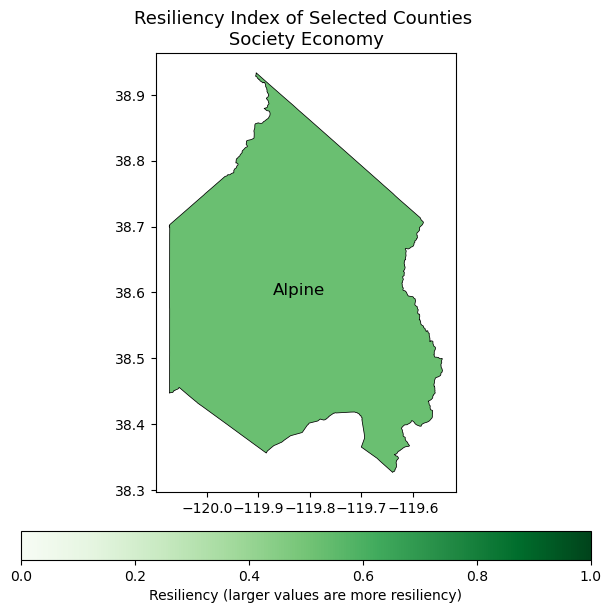

In [25]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_society_economy_domain, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


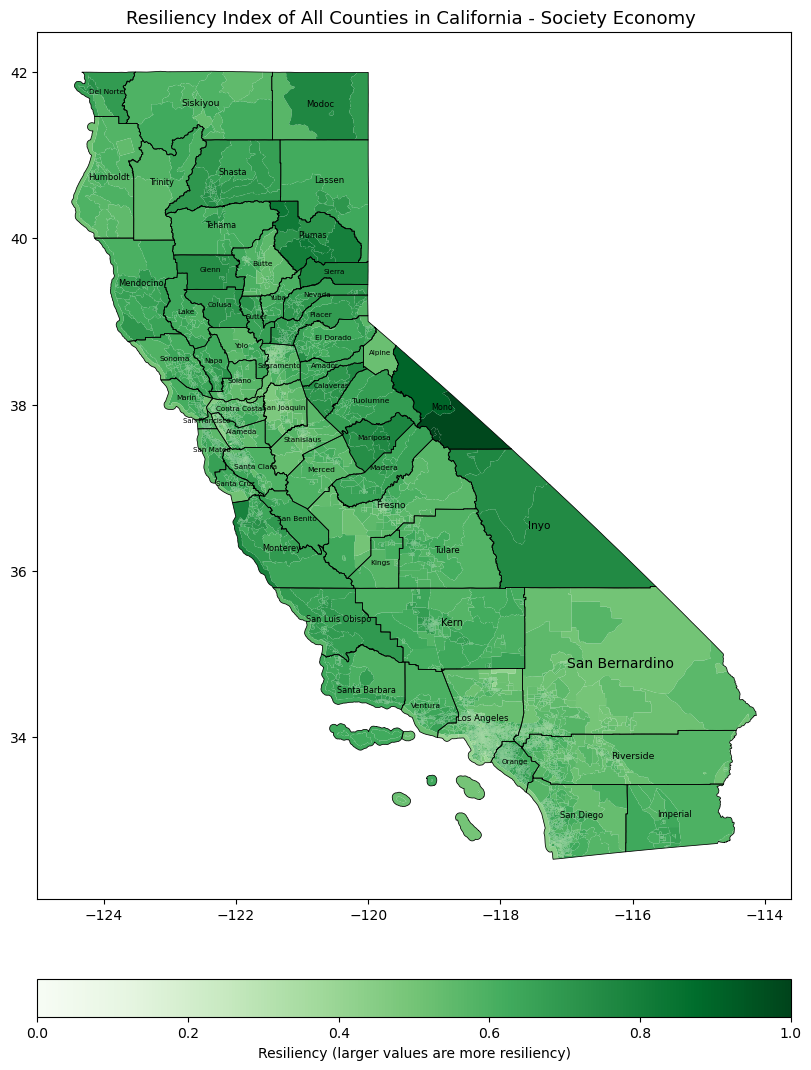

In [26]:
plot_region_domain(min_max_standardized_society_economy_domain, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [27]:
# set-up file for export
domain_filename = '{}domain_index_calculation.csv'.format(domain_prefix)
gdf.to_csv(domain_filename, index=False)

In [28]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

society_economy_domain_averaged_indicators.csv uploaded to AWS
society_economy_domain_index_calculation.csv uploaded to AWS
